In [1]:
NAME = "Minhajul Abedin"
ID = "18301224"
COLLABORATORS_ID = ["", ""]

# **CSE428 Week 9 Coding Assignment**

In this assignment we would like to implement a simple version of the following Block Transform Coding for the JPEG compression standard. Finally, we would calculate the $SNR$ for different scenarios.

We would assume that the symbol encoding and decoding are lossless (reasonable assumption) and hence we would not implement the "Symbol encoder" and "Symbol decoder" blocks.

In [2]:
%%html
<center>
<iframe src="https://drive.google.com/file/d/1U0xD_HJLU4zW7hjG-W_iLFeCaioaoDlZ/preview" width="60%" height="60%"></iframe></center>

For a overview of the JPEG compression algorithm, the following Computerphile videos might be helpful for better understanding:


> https://youtu.be/LFXN9PiOGtY <br>
> https://youtu.be/n_uNPbdenRs <br>
> https://youtu.be/Q2aEzeMDHMA





In [3]:
# imports
from scipy.fftpack import fft, dct, dctn, idct, idctn
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

In [4]:
# Helper function for plotting images

def plot_image(img,figsize=(5,5)):
    plt.figure(figsize=figsize)
    if len(img.shape)==2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.show()
    print("Image shape: ", img.shape)

## Step 1: Import the image

In [5]:
image = io.imread('sample.jpeg') 

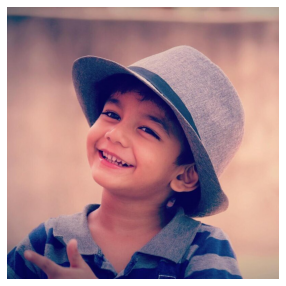

Image shape:  (800, 800, 3)


In [6]:
plot_image(image)

## Step 2: Convert the RGB image to YCbCr color space

In [7]:
from skimage.color import rgb2ycbcr

In [8]:
image_ycbcr = rgb2ycbcr(image)

In [9]:
Y, Cb, Cr = image_ycbcr[:,:,0], image_ycbcr[:,:,1], image_ycbcr[:,:,2]

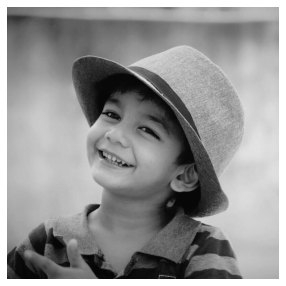

Image shape:  (800, 800)


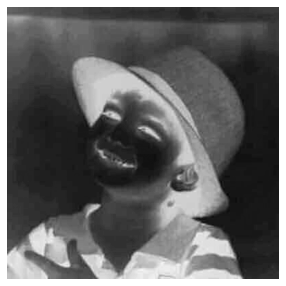

Image shape:  (800, 800)


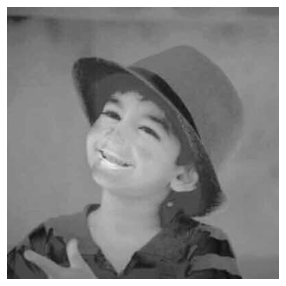

Image shape:  (800, 800)


In [10]:
plot_image(Y)
plot_image(Cb)
plot_image(Cr)

## Step 3: Block Transform Encoder (DCT Based Compression)

## Step 3.1 Write a sub routine for calculating DCT & Normalization of 8x8 subimages

In [11]:
# Define Z

Z = np.array([[ 16, 11, 10, 16, 24, 40, 51, 61],
              [ 12, 12, 14, 19, 26, 58, 60, 55],
              [ 14, 13, 16, 24, 40, 57, 69, 56],              
              [ 14, 17, 22, 29, 51, 87, 80, 62],
              [ 18, 22, 37, 56, 68,109,103, 77],
              [ 24, 35, 55, 64, 81,104,113, 92],
              [ 49, 64, 78, 87,103,121,120, 101],
              [ 72, 92, 95, 98,112,100,130, 99]])

In [12]:
def subimageDCT(F):
    return dctn(F, norm='ortho')

In [13]:
def subimageNormalization(T, Z):
    return np.round(T/Z) 

## 3.2 Loop over the Y Cb Cr for 8x8 blocks and perform DCT + Normalization

In [14]:
def compressed(I,  Z):
  I_compressed = np.zeros_like(I)
  I = I.copy()
  height = I.shape[0]// 8
  weight= I.shape[1] // 8
  for h in range(height):
    s_h, f_h = 8*h, 8*(h+1)
    for w in range(weight):
      s_w, f_w = 8*w, 8*(w+1)
      I_compressed[s_h:f_h, s_w:f_w] = subimageDCT(I[s_h:f_h, s_w:f_w])
      I_compressed[s_h:f_h, s_w:f_w] = subimageNormalization(I_compressed[s_h:f_h, s_w:f_w], Z) 
  return I_compressed

Y_compressed = compressed(Y, Z)
Cb_compressed = compressed(Cb, Z)
Cr_compressed = compressed(Cr, Z)

## Step 4: Block Transform Decoder (DCT Based Decompression)

## Step 4.1 Write a sub routine for calculating IDCT & Denormalization of 8x8 subimages

In [15]:
def subimageDeNormalization(T, Z):
    return np.round(T*Z)

In [16]:
def subimageIDCT(T):
    return idctn(T, norm='ortho')

## 4.2 Loop over the compressed Y Cb Cr for 8x8 blocks and perform IDCT + Denormalization

In [17]:
def decompressed(I,  Z):
  I_decompressed = np.zeros_like(I)
  for h in range(Y.shape[0]//8):
    for w in range(Y.shape[0]//8):
      s_h, f_h = 8*h, 8*(h+1)
      s_w, f_w= 8*w, 8*(w+1)
      I_decompressed[s_h:f_h, s_w:f_w] = subimageDeNormalization(I[s_h:f_h, s_w:f_w], Z)
      I_decompressed[s_h:f_h, s_w:f_w] = subimageIDCT(I_decompressed[s_h:f_h, s_w:f_w])

  return I_decompressed

Y_decompressed = decompressed(Y_compressed, Z)
Cb_decompressed = decompressed(Cb_compressed, Z)
Cr_decompressed = decompressed(Cr_compressed, Z)

# Step 5: Convert the decompressed YCbCr image to RGB color space

## Step 5.1 Stack the decompressed Y, Cb, Cr components to create a 3D volume

In [18]:
image_ycbcr_decompressed = np.concatenate((np.expand_dims(Y_decompressed, axis=-1),
                                           np.expand_dims(Cb_decompressed, axis=-1),
                                           np.expand_dims(Cr_decompressed, axis=-1)), axis=-1)

## Step 5.2 Convert the decompressed YCbCr image to RGB

In [19]:
from skimage.color import ycbcr2rgb
image_decompressed = ycbcr2rgb(image_ycbcr_decompressed)


# Step 6: Calculate $SNR_{ms}$ for $Z, 2Z\,\&\, 5Z$



In [20]:
#TO-DO
def SNR(I_hat, I):
  return np.sum(I_hat) / np.sum((I_hat - I) ** 2)

def decompressed_image(Y, Cb, Cr, Z):
  Y_decompressed = decompressed(compressed(Y, Z), Z)
  Cb_decompressed = decompressed(compressed(Cb, Z), Z)
  Cr_decompressed = decompressed(compressed(Cr, Z), Z)
  image_decomp = ycbcr2rgb(np.concatenate((np.expand_dims(Y_decompressed, axis=-1),
                                            np.expand_dims(Cb_decompressed, axis=-1),
                                            np.expand_dims(Cr_decompressed, axis=-1)), axis=-1))
  return image_decomp

image_decompressed_2Z = decompressed_image(Y, Cb, Cr, 2*Z)
image_decompressed_5Z = decompressed_image(Y, Cb, Cr, 5*Z)

image_decompressed = np.clip(image_decompressed, 0, 1)
image_decompressed_2Z = np.clip(image_decompressed_2Z, 0, 1)
image_decompressed_5Z = np.clip(image_decompressed_5Z, 0, 1)

SNR_Z = SNR(image_decompressed, image)
SNR_2Z = SNR(image_decompressed_2Z, image)
SNR_5Z = SNR(image_decompressed_5Z, image)



print("SNRms for Z: ", SNR_Z)
print("SNRms for 2Z: ", SNR_2Z)
print("SNRms for 5Z: ", SNR_5Z)

SNRms for Z:  2.478547059651485e-05
SNRms for 2Z:  2.4783929089516144e-05
SNRms for 5Z:  2.4768070789876867e-05


In [21]:
print(image_decompressed_5Z.min(), " ", image_decompressed_5Z.max())

0.0   1.0


# Step 7: Plot the decompressed images of the original image, along with the original uncompressed image in a 1x4 subplot for $Z, 2Z\,\&\, 5Z$

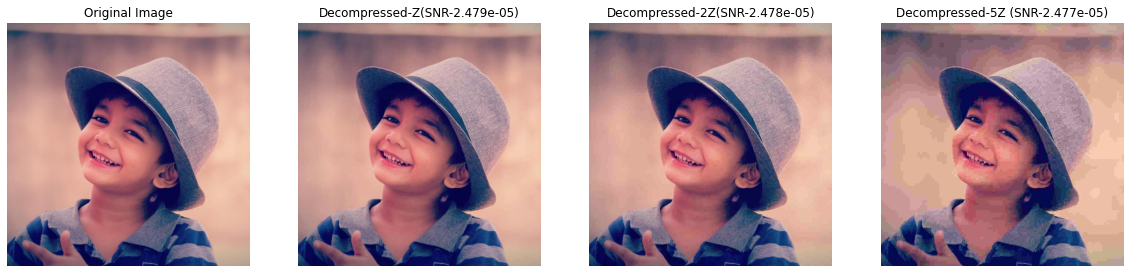

In [22]:
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image_decompressed)
plt.title(f"Decompressed-Z(SNR-{SNR_Z:.4})")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(image_decompressed_2Z)
plt.title(f"Decompressed-2Z(SNR-{SNR_2Z:.4})")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_decompressed_5Z)
plt.title(f"Decompressed-5Z (SNR-{SNR_5Z:.4})")

plt.axis('off')
plt.show()

**Finding - 1:** If we compare the compression and decompression with Z, 2Z and 5Z, We can examine that the higher value of Z is giving high compression and after decompression the quality of the image qulititively and quantitively become lower. Although we can not differentiate compression with Z and 2Z  visually but quantitively SNR ration with 2Z is lower then 2Z. However, we can clearely determine the result of compression/decompression with 5Z both qualititively and quantitively. Therefore, lower vlaue of Z mean lower compression and higher value mean higher compression.

# Step 8: Additional experimentation. Feel free to play with the code that you just developed and report your findings. For example, you may try a different quantization matrix $Z$ or use different $Z$s dor different channels, etc. This is a bonus task.

In [23]:
# TZ = np.random.randint(200, high=300, size=(8,8))
TZ_90 = np.rot90(Z,1)
TZ_180 = np.rot90(Z, 2)
TZ_270 = np.rot90(Z, 3)

print('Z after rotating 180 degree:')
print(TZ_180)
image_decompressed_TZ90 = np.clip(decompressed_image(Y, Cb, Cr, TZ_90), 0, 1)
image_decompressed_TZ180 = np.clip(decompressed_image(Y, Cb, Cr, TZ_180), 0, 1)
image_decompressed_TZ270 = np.clip(decompressed_image(Y, Cb, Cr, TZ_270), 0, 1)


SNR_TZ90 = SNR(image_decompressed_TZ90, image)
SNR_TZ180 = SNR(image_decompressed_TZ180, image)
SNR_TZ270 = SNR(image_decompressed_TZ270, image)



Z after rotating 180 degree:
[[ 99 130 100 112  98  95  92  72]
 [101 120 121 103  87  78  64  49]
 [ 92 113 104  81  64  55  35  24]
 [ 77 103 109  68  56  37  22  18]
 [ 62  80  87  51  29  22  17  14]
 [ 56  69  57  40  24  16  13  14]
 [ 55  60  58  26  19  14  12  12]
 [ 61  51  40  24  16  10  11  16]]


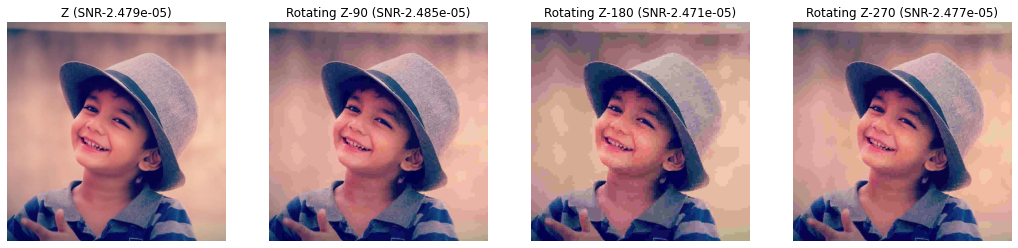

In [24]:
plt.figure(figsize=(18,18))
plt.subplot(1,4,1)
plt.imshow(image_decompressed)
plt.title(f"Z (SNR-{SNR_Z:.4})")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(image_decompressed_TZ90)
plt.title(f"Rotating Z-90 (SNR-{SNR_TZ90:.4})")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(image_decompressed_TZ180)
plt.title(f"Rotating Z-180 (SNR-{SNR_TZ180:.4})")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(image_decompressed_TZ270)
plt.title(f"Rotating Z-270 (SNR-{SNR_TZ270:.4})")
plt.axis('off')
plt.show()

**Finding - 2:** If we take new TZ by rotating the Z array by 180 or 270 degree, left values of diagonal become greater than the right values of diagonal. After doing compression and decompression with the TZ, we can see the SNR ration is lower then compression and decompression with Z. Also, visually the quality is low in this case. Thus, lower values in the left side of the diagonal compare to right side values of diagnoal give better quality quantitively and qualitatively.

(-0.5, 799.5, 799.5, -0.5)

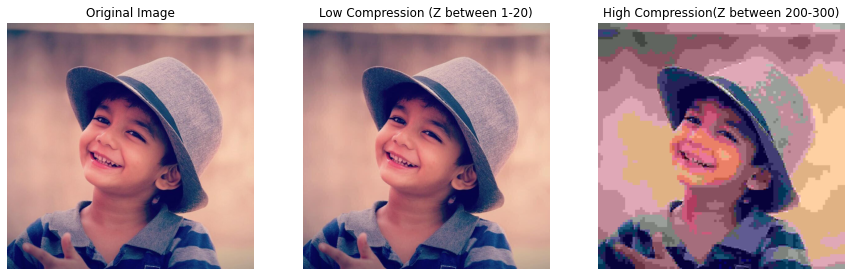

In [26]:
TZ1 = np.random.randint(1, high=20, size=(8,8))
TZ2 = np.random.randint(200, high=300, size=(8,8))

image_decompressed_test_TZ1 = np.clip(decompressed_image(Y, Cb, Cr, TZ1), 0, 1)
image_decompressed_test_TZ2 = np.clip(decompressed_image(Y, Cb, Cr, TZ2), 0, 1)



plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_decompressed_test_TZ1)
plt.title("Low Compression (Z between 1-20)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_decompressed_test_TZ2)
plt.title("High Compression(Z between 200-300)")
plt.axis('off')

**Finding - 3:** The image quality is high when decompressed after low compression. On the other hand, decompressing a higher compressed image have too much quality drop and saturation in image. If we want low compression then we should use lower value for Z. Coverstly we should use higher values of Z for higher compression.